In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
np.set_printoptions(legacy='1.25')
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['errorbar.capsize'] = 12
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

enss=['b']
ens2full={'a24':'cA211.53.24','a':'cA2.09.48','b':'B64','c':'C80','d':'D96'}
ens2label={'a24':'A24','a':'A48','b':'B64','c':'C80','d':'D96'}
ens2a={'a24':0.0908,'a':0.0938,'b':0.07957,'c':0.06821,'d':0.05692} # fm
ens2N={'a24':24,'a':48,'b':64,'c':80,'d':96}
ens2N_T={'a24':24*2,'a':48*2,'b':64*2,'c':80*2,'d':96*2}

# ens2mN={'a':931}
# ens2mpiC={'a':131}
# ens2mpi0={'a':111}

ens2amu={'a24':0.0053,'a':0.0009,'b':0.00072}
ens2ZP={'a24':(0.4670,0.0046),'a':(0.500,0.030)}

hbarc = 1/197.3
ens2aInv={ens:1/(ens2a[ens]*hbarc) for ens in enss} # MeV

ens='b'

In [2]:
Tpack=32; d_jk=1
path='/capstor/store/cscs/userlab/s1174/lyan/code/projectData2/01_Nsgm/cB211.072.64_base/data_merge/Nsgm_4src_16,18,20.h5'
data=yu.load(path,d=d_jk)
Ncfg,Njk=data['cfgs'][1:]
print(f'Ncfg={Ncfg},Njk={Njk}')

cfg2old=lambda cfg: cfg[1:]+'_r'+{'a':'0','b':'1','c':'2','d':'3'}[cfg[0]]
cfg2new=lambda cfg: {'0':'a','1':'b','2':'c','3':'d'}[cfg[-1]] + cfg[:4]

tfs=[8,10,12,14,16,18,20]
path='/capstor/store/cscs/userlab/s1174/lyan/code/projectData2/01_Nsgm/cB211.072.64_base/data_from_others/thrp-conn.h5'
with h5py.File(path) as f:
    # cfgs_NJN=[cfg2new(cfg) for cfg in f['gS/up/dt10'].keys()]
    cfgs_old=[cfg2old(cfg) for cfg in data['cfgs'][0]]

    c3ptDic_NJN={tf:np.real(yu.jackknife([f[f'gS/up/dt{tf}/{cfg}'][:] + f[f'gS/dn/dt{tf}/{cfg}'][:] for cfg in cfgs_old],d=d_jk)) for tf in tfs}
    c2ptCorrDic_NJN={tf:np.real(yu.jackknife([f[f'dt{tf}_twop/{cfg}'][()] for cfg in cfgs_old],d=d_jk)) for tf in tfs}

loading: /capstor/store/cscs/userlab/s1174/lyan/code/projectData2/01_Nsgm/cB211.072.64_base/data_merge/Nsgm_4src_16,18,20.h5
482/482: diags/Z3pt/srcs/Z3pt.h5_NJNpi-Nsrc=4*1                               
Ncfg=732,Njk=732


In [3]:
flags={
    'cc2pt':True, # average quantities related by complex conjugation for 2pt
    'cc3pt':True, # same for 3pt (Removal of vacuum expectation value requires 'cc2pt'=='cc3pt')
    'll2pt':True, # average irrep rows 'l1' and conjugated 'l2' (Parity breaking effect of tmQCD has been taken care of)
    'll3pt':True, # same for 3pt (This flag has no effect if 'll2pt'=True and spin-projection is done)
    'r2pt': True, # making 2ptMat real for the rest frame # 'll2pt' has to be real for this flag
    'remove_pi0VEV':True, 
    'remove_jVEV':True,
}

def op_remove_pi0(op):
    t=op.split(';')
    if t[-1] in ['p','n','n,pi+']:
        return False
    if t[3] not in ['N0pi0,a','N1pi0,a','N0sgm0,a','N1sgm0,a']:
        return False
    if t[3] in ['N0sgm0,a','N1sgm0,a']:
        t[3]='a'
        t[-1]={'p,sgm':'p'}[t[-1]]
        return ';'.join(t)
    if t[2] == 'G1u':
        t[2]='G1g'
        assert(t[3]=='N0pi0,a'); t[3]='a'
        assert(t[-1]=='p,pi0'); t[-1]='p'
        return ';'.join(t)

def get2pt_diag(opa,opb,diag):
    opab=f'{opa}_{opb}'
    if opab not in data['2pt'].keys() or diag not in data['2pt'][opab].keys():
        return 0
    res=data['2pt'][opab][diag].copy()
    if not flags['remove_pi0VEV']:
        return res
    if diag == 'pi0f-pi0i':
        if opa==opb and opa=='t;0,0,0;pi0':
            res -= (data['VEV']['pi0f']**2)[:,None]
        return res
    
    if 'pi0f' in diag.split('-'):
        t_opa=op_remove_pi0(opa)
        if t_opa != False:
            t=diag.split('-'); t.remove('pi0f'); t_diag='-'.join(t)
            res -= data['2pt'][f'{t_opa}_{opb}'][t_diag] * data['VEV']['pi0f'][opa.split(';')[-1].split(',')[-1]][:,None]
    if 'pi0i' in diag.split('-'):
        t_opb=op_remove_pi0(opb)
        if t_opb != False:
            t=diag.split('-'); t.remove('pi0i'); t_diag='-'.join(t)
            res -= data['2pt'][f'{opa}_{t_opb}'][t_diag] * np.conj(data['VEV']['pi0f'][opb.split(';')[-1].split(',')[-1]][:,None])
    if 'pi0f' in diag.split('-') and 'pi0i' in diag.split('-'):
        t_opa=op_remove_pi0(opa); t_opb=op_remove_pi0(opb)
        if t_opa != False and t_opb != False:
            t=diag.split('-'); t.remove('pi0f'); t.remove('pi0i'); t_diag='-'.join(t)
            res += data['2pt'][f'{t_opa}_{t_opb}'][t_diag] * data['VEV']['pi0f'][opa.split(';')[-1].split(',')[-1]][:,None] * np.conj(data['VEV']['pi0f'][opb.split(';')[-1].split(',')[-1]][:,None])
    return res

def get2pt(opa,opb,diags=yu.diags_all):
    res=np.zeros([Njk,Tpack],dtype=complex)
    opab=f'{opa}_{opb}'; opba=f'{opb}_{opa}'
    if opab in data['2pt']:
        res+=np.sum([get2pt_diag(opa,opb,diag) for diag in data['2pt'][opab].keys() if diag in diags],axis=0)
    if opba in data['2pt']:
        diags_cc={'T', 'T-pi0f'}; 
        res+=np.conj(np.sum([get2pt_diag(opa,opb,diag) for diag in data['2pt'][opba].keys() if diag in diags_cc and diag in diags],axis=0))
    return res

def get2ptMat(ops,diags=yu.diags_all):
    if flags['ll2pt']:
        flags['ll2pt']=False
        ops_flip=[yu.op_flipl(op) for op in ops]
        t=(get2ptMat(ops,diags=diags)+np.conj(get2ptMat(ops_flip,diags=diags)))/2
        flags['ll2pt']=True
        if ops[0].split(';')[1]=='0,0,0' and flags['r2pt']:
            t=np.real(t)
        return t
    t=np.transpose([[get2pt(opa,opb,diags) for opb in ops] for opa in ops],[2,3,0,1])
    if flags['cc2pt']:
        t=(t+np.conj(np.transpose(t,[0,1,3,2])))/2
    return t

tfs=[8,10,12,14,16,18,20]

def get3pt_diag(opa,opb,insert,diag):
    if opa in ['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;a;l2;p'] and opb in ['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;a;l2;p'] and insert.startswith('id_j+_') and diag=='NJN':
        gm,j,tf=insert.split('_')
        res=c3ptDic_NJN[int(tf)]
        return res
    
    opab=f'{opa}_{opb}'
    if opab not in data['3pt'].keys() or diag not in data['3pt'][opab][insert].keys():
        return 0
    res=data['3pt'][opab][insert][diag].copy()
    if flags['remove_pi0VEV']:
        if 'pi0f' in diag.split('-'):
            t_opa=op_remove_pi0(opa)
            if t_opa != False:
                t=diag.split('-'); t.remove('pi0f'); t_diag='-'.join(t)
                res -= data['3pt'][f'{t_opa}_{opb}'][insert][t_diag] * data['VEV']['pi0f'][opa.split(';')[-1].split(',')[-1]][:,None]
        if 'pi0i' in diag.split('-'):
            t_opb=op_remove_pi0(opb)
            if t_opb != False:
                t=diag.split('-'); t.remove('pi0i'); t_diag='-'.join(t)
                res -= data['3pt'][f'{opa}_{t_opb}'][insert][t_diag] * np.conj(data['VEV']['pi0f'][opb.split(';')[-1].split(',')[-1]][:,None])
        if 'pi0f' in diag.split('-') and 'pi0i' in diag.split('-'):
            t_opa=op_remove_pi0(opa); t_opb=op_remove_pi0(opb)
            if t_opa != False and t_opb != False:
                t=diag.split('-'); t.remove('pi0f'); t.remove('pi0i'); t_diag='-'.join(t)
                res += data['3pt'][f'{t_opa}_{t_opb}'][insert][t_diag] * data['VEV']['pi0f'][opa.split(';')[-1].split(',')[-1]][:,None] * np.conj(data['VEV']['pi0f'][opb.split(';')[-1].split(',')[-1]][:,None])
    if flags['remove_jVEV']:
        gm,j,tf=insert.split('_')
        t_insert='_'.join([gm,j])
        if 'j' in diag.split('-') and t_insert in ['id_j+','id_js','id_jc','g5_j-']:
            t=diag.split('-'); t.remove('j'); t_diag='-'.join(t)
            res -= (get2pt_diag(opa,opb,t_diag)[:,int(tf)] * data['VEV']['j'][t_insert])[:,None]
    return res

def get3pt(opa,opb,insert,diags=yu.diags_all):
    res=np.zeros([Njk,int(insert.split('_')[-1])+1],dtype=complex)
    opab=f'{opa}_{opb}'; opba=f'{opb}_{opa}'
    if opab in data['3pt']:
        res+=np.sum([get3pt_diag(opa,opb,insert,diag) for diag in data['3pt'][opab][insert].keys() if diag in diags],axis=0)
    if opba in data['3pt']:
        t=data['3pt'][opb+'_'+opa][insert]; 
        diags_cc={'B3pt','W3pt','Z3pt','T-j', 'T-pi0f-j','T-jPf','B3pt-pi0f','W3pt-pi0f','Z3pt-pi0f'}; 
        if opab not in data['3pt'] or 'NJN-pi0f' not in data['3pt'][opab][insert]:
            diags_cc.add('NJN-pi0i')
        t_add=np.zeros([Njk,int(insert.split('_')[-1])+1],dtype=complex)+np.sum([get3pt_diag(opb,opa,insert,diag) for diag in t.keys() if diag in diags_cc and diag in diags],axis=0)
        res+=np.conj(t_add[:,::-1])*(yu.gtCj[insert.split('_')[0]])
    return res

def get3ptMat(opas,opbs,insert,diags=yu.diags_all):
    if flags['ll3pt']:
        flags['ll3pt']=False
        opas_flip=[yu.op_flipl(op) for op in opas]; opbs_flip=[yu.op_flipl(op) for op in opbs]
        sgns=np.array([[yu.op_getl_sgn(opa)*yu.op_getl_sgn(opb) for opb in opbs] for opa in opas])
        sgns*=yu.fourCPTstar[insert.split('_')[0]]
        t=(get3ptMat(opas,opbs,insert,diags=diags)+np.conj(get3ptMat(opas_flip,opbs_flip,insert,diags=diags))*sgns[None,None,:,:])/2
        flags['ll3pt']=True
        return t
    t=np.transpose([[get3pt(opa,opb,insert,diags) for opb in opbs] for opa in opas],[2,3,0,1])
    if flags['cc3pt']:
        flags['cc3pt']=False
        tt=get3ptMat(opbs,opas,insert,diags)[:,::-1]*(yu.gtCj[insert.split('_')[0]])
        flags['cc3pt']=True
        t=(t+np.conj(np.transpose(tt,[0,1,3,2])))/2
    return t

In [4]:
ops=['g;0,0,0;G1g;a;l1;p','g;0,0,0;G1g;N0sgm0,a;l1;p,sgm']
j='j+'; tfs=[8,10,12,14,16,18,20]

c2ptM=get2ptMat(ops)
c3ptM_dic={tf:get3ptMat(ops,ops,f'id_{j}_{tf}',diags=yu.diags_all) for tf in tfs}

# GEVP_t0,GEVP_t=7,14
# evals,evecs=yu.GEVP(np.mean(c2ptM,axis=0),GEVP_t0)
# Revec=evecs[GEVP_t,0,1]/evecs[GEVP_t,0,0]
# print(Revec)

c2ptN=np.real(c2ptM[:,:,0,0])
c2ptNNsgm=np.real(c2ptM[:,:,0,1])
c2ptNsgmNsgm=np.real(c2ptM[:,:,1,1])
c3ptN_dic={tf:np.real(c3ptM_dic[tf][:,:,0,0]) for tf in tfs}
c3ptNNsgm_dic={tf:np.real(c3ptM_dic[tf][:,:,0,1]) for tf in tfs}

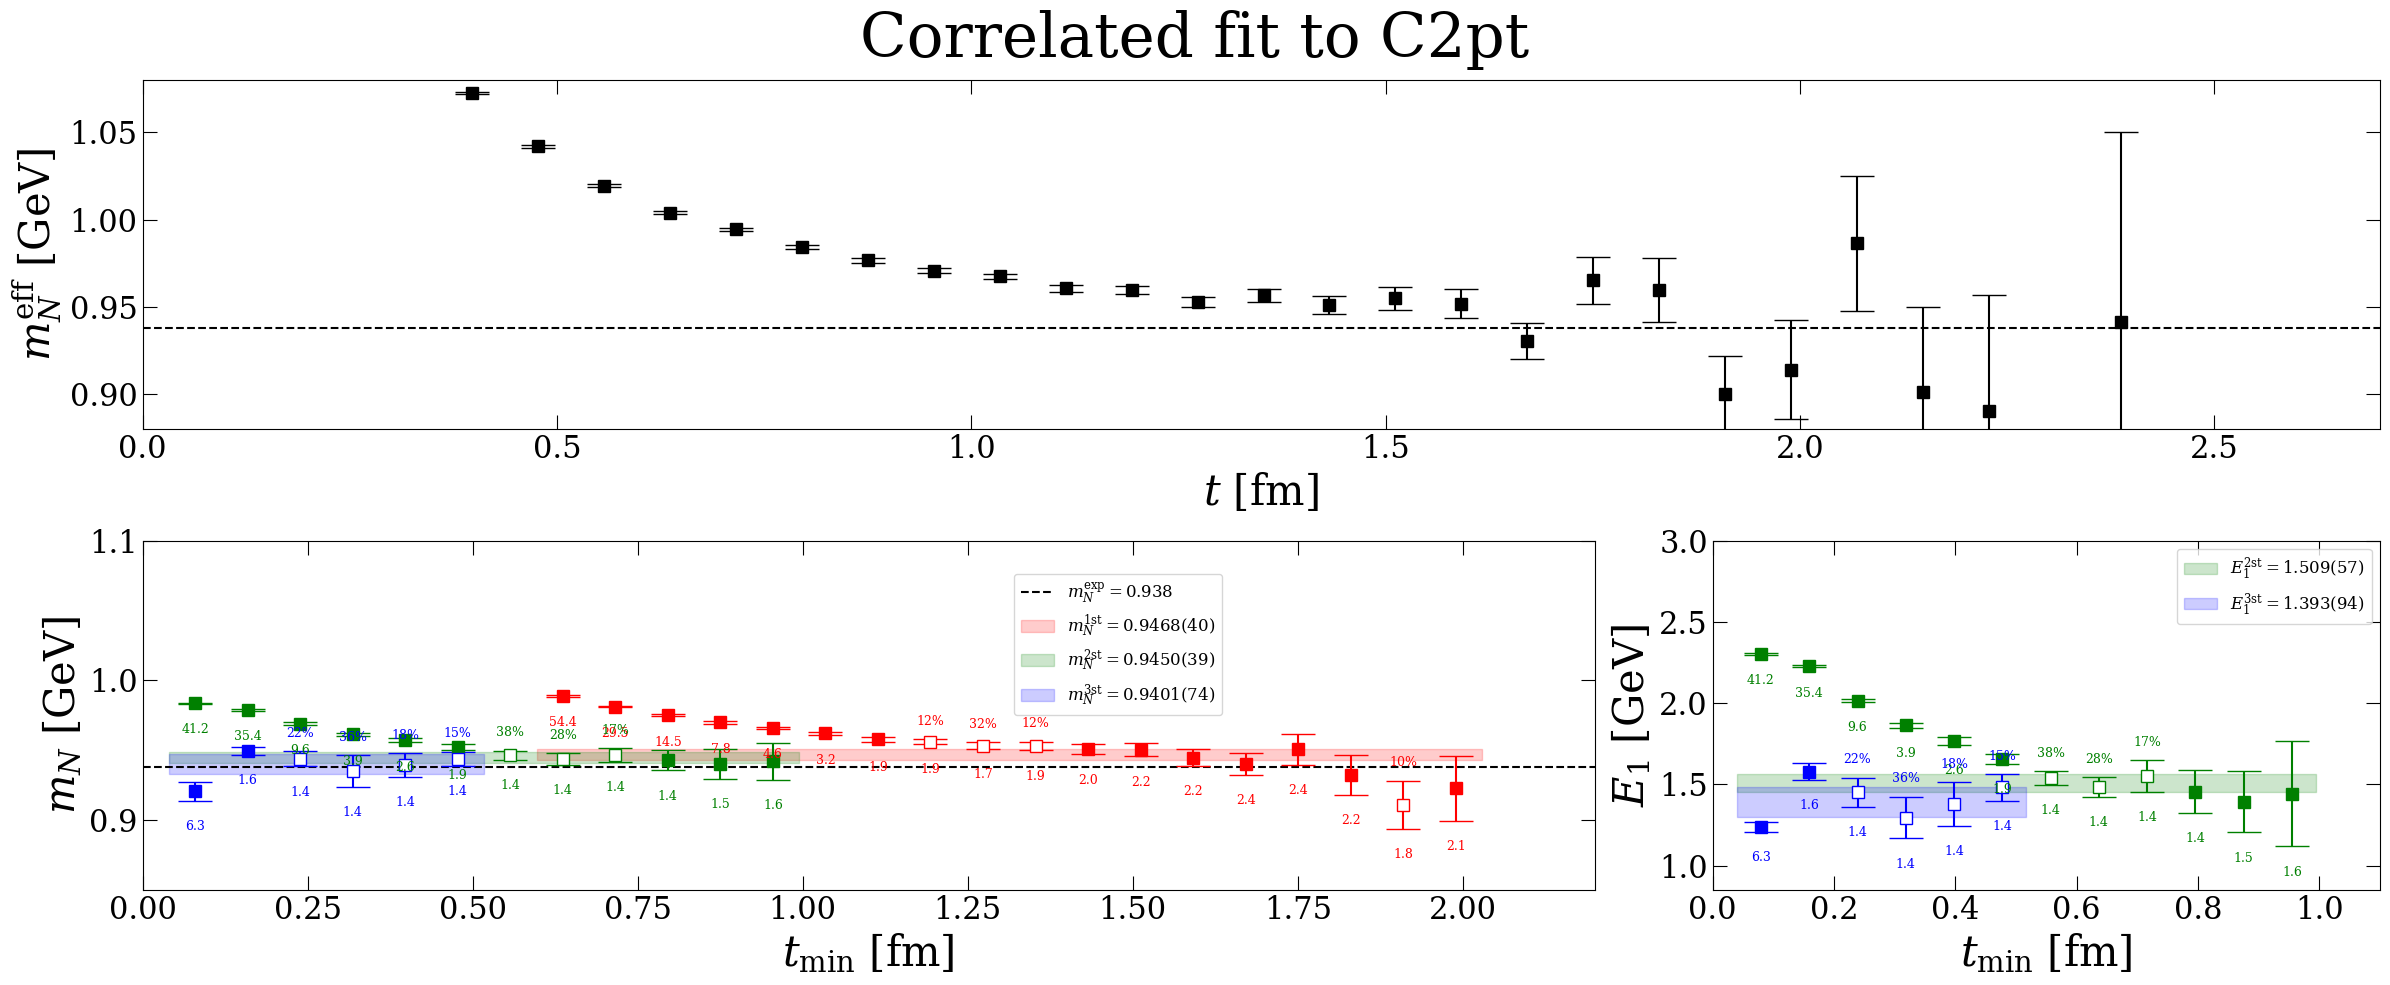

In [5]:
def c2Hankle(c,ts,shift=0):
    tmax=len(c)-np.max(ts)*2 - shift
    return np.array([[[c[t+i+j+shift] for i in ts] for j in ts] for t in range(tmax)])    

propThreshold=0.1
# propThreshold=None

chi2Size=9
settings={}

func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_C2pt_4st=lambda t,E0,c0,dE1,rc1,dE2,rc2,dE3,rc3: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t) + rc3*np.exp(-dE3*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

def run(corrQ=False,meffQ=True,pdf=None):
    xunit=ens2a[ens]; yunit=ens2aInv[ens]/1000
    fig, axd = plt.subplot_mosaic([['f1','f1','f1'],['f2','f2','f3']],figsize=(24,10))
    (ax1,ax2,ax3)=(axd[key] for key in ['f1','f2','f3'])
    if meffQ:
        fig.suptitle('Correlated fit to meff' if corrQ else 'Uncorrelated fit to meff',fontsize=44)
    else:
        fig.suptitle('Correlated fit to C2pt' if corrQ else 'Uncorrelated fit to C2pt',fontsize=44)
    
    ax1.set_xlabel(r'$t$ [fm]')
    ax2.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
    ax3.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
    ax1.set_ylabel(r'$m_N^{\mathrm{eff}}$ [GeV]')
    ax2.set_ylabel(r'$m_N$ [GeV]')
    ax3.set_ylabel(r'$E_1$ [GeV]')
    ax1.set_ylim(settings['ylim1'])
    ax2.set_ylim(settings['ylim2'])
    # ax2.set_ylim([0.8,1.2])
    ax3.set_ylim(settings['ylim3'])
    ax1.set_xlim(settings['xlim1'])
    ax2.set_xlim(settings['xlim2'])
    ax3.set_xlim(settings['xlim3'])
    
    mN_exp=0.938; mp_exp,mn_exp=(0.93827,0.93957)
    ax1.axhline(y=mN_exp,color='black',linestyle = '--', marker='')
    ax2.axhline(y=mN_exp,color='black',linestyle = '--', marker='', label=r'$m_N^{\mathrm{exp}}=$'+'%0.3f'%mN_exp)
    C2pt_jk=c2ptN
    C2pt_mean,C2pt_err=yu.jackme(C2pt_jk)
    C2pt_rela=np.abs(C2pt_err/C2pt_mean)
    func=lambda C2pt: np.log(C2pt/np.roll(C2pt,-1,axis=0))
    mEff_jk=yu.jackmap(func,C2pt_jk)
    (mEff_mean,mEff_err)=yu.jackme(mEff_jk)
    mEff_rela=np.abs(mEff_err/mEff_mean)
    temp=[(i,rela) for i,rela in enumerate(mEff_rela if meffQ else C2pt_rela) if rela>0.2 and i!=0]
    fitmax=temp[0][0]-1 if len(temp)!=0 else len(C2pt_mean)-1
    
    tmin=1; tmax=fitmax+1
    plt_x=np.arange(tmin,tmax)*xunit; plt_y=mEff_mean[tmin:tmax]*yunit; plt_err=mEff_err[tmin:tmax]*yunit
    ax1.errorbar(plt_x,plt_y,plt_err,color='black',fmt='s')

    pars0_initial=[0.4,0.5,2,0.8,1] if meffQ else [0.4,1e-8,0.5,2,0.8,1,1.2,1]
    DNpar=1 if meffQ else 0
    
    fits_all=[]
    # 1st fits
    color='r'
    fitmins=settings['fitmins_1st']
    pars0=pars0_initial[:2-DNpar]
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_1st(tList,*pars)
            return func_C2pt_1st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('1st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
        
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars_mean,pars_err=yu.jackme(pars_jk)
    pars0=pars_mean
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2,label=r'$m_N^{\mathrm{1st}}=$'+yu.un2str(plt_y,plt_err))
    # ax1.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2)
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
    
    # 2st fits
    color='g'
    fitmins=settings['fitmins_2st']
    pars0=np.hstack([pars0,pars0_initial[2-DNpar:4-DNpar]])
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_2st(tList,*pars)
            return func_C2pt_2st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('2st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    res=pars_jk
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars0=yu.jackme(pars_jk)[0]
    pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
    # ax1.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2)
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
    ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
        plt_x=fitmin*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
        ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
    # 3st fits
    color='b'
    fitmins=settings['fitmins_3st']
    pars0=np.hstack([pars0,pars0_initial[4-DNpar:6-DNpar]])
    if ens=='c' and (corrQ,meffQ)==(False,False):
        pars0=[3.25069715e-01, 1.88384811e-09, 1.78883939e-01, 6.35351339e-01, 6.98775484e-01, 4.58702896e+01]
    # elif ens=='d' and (corrQ,meffQ)==(False,False):
    #     pars=[2.72824764e-01, 3.72721072e-10, 1.84246641e-01, 7.65383428e-01, 6.98775484e-01, 4.58702896e+01]
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_3st(tList,*pars)
            return func_C2pt_3st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('3st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars0=yu.jackme(pars_jk)[0]
    # print(pars0)
    pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{3st}}=$'+yu.un2str(plt_y,plt_err))
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
    ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{3st}}=$'+yu.un2str(plt_y,plt_err))    
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
        plt_x=fitmin*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
        ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 
        if propThreshold is not None and prop>propThreshold:
            ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
    
    # color='orange'
    # pars_jk,props_jk=yu.jackMA(fits_all)
    # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    # pars_mean,pars_err=yu.jackme(pars_jk)
    # plt_x=settings['xlim2']; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    # ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{nst}}=$'+yu.un2str(plt_y,plt_err) + f'; MPF: {fits_all[ind_mpf][0][0]}')    
    
    ax2.legend(loc=(0.6,0.5),fontsize=12)
    ax3.legend(fontsize=12)
    
    plt.tight_layout()
    # if pdf!=None:
    #     pdf.savefig(fig)
    # else:
    #     if meffQ:
    #         plt.savefig('fig/fit_meff_cor.pdf' if corrQ else 'fig/fit_meff_unc.pdf')
    #     else:
    #         plt.savefig('fig/fit_2pt_cor.pdf' if corrQ else 'fig/fit_2pt_unc.pdf')
    # plt.close()
    return res

for ens in ['b']:
    if ens=='b':
        settings={
            'fitmins_1st':range(8,25+1),
            'fitmins_2st':range(1,12+1),
            'fitmins_3st':range(1,6+1),
            'fitmins_4st':[2,1],
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    elif ens=='c':
        settings={
            'fitmins_1st':range(8,29+1),
            'fitmins_2st':range(1,18+1),
            'fitmins_3st':range(1,8+1),
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    elif ens=='d':
        settings={
            'fitmins_1st':range(8,34+1),
            'fitmins_2st':range(1,21+1),
            'fitmins_3st':range(1,7+1),
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    else:
        settings={
            'fitmins_1st':range(8,20+1),
            'fitmins_2st':range(1,12+1),
            'fitmins_3st':range(1,6+1),
            'fitmins_4st':[2,1],
            'ylim1':[0.6,1.7],
            'ylim1':[0.88,1.08],
            'ylim2':[0.85,1.1],
            'ylim3':[0.85,3.0],
            'xlim1':[0,2.7],
            'xlim2':[0,2.2],
            'xlim3':[0,1.1],
        }
    # res2pt={}
    # import matplotlib.backends.backend_pdf
    # pdf = matplotlib.backends.backend_pdf.PdfPages(f"fig/fit2pt_{ens}.pdf")
    # res2pt[(True,True)]=run(True,True,pdf=pdf)
    # res2pt[(True,False)]=run(True,False,pdf=pdf)
    # res2pt[(False,True)]=run(False,True,pdf=pdf)
    # res2pt[(False,False)]=run(False,False,pdf=pdf)
    # pdf.close()
    
    pars_jk_c2ptN_2st=run(True,False)

In [6]:
func_c3ptN=lambda tf,tc,E0,dE1,dE2,a00,ra01,ra11,ra02: a00*np.exp(-E0*tf) * ( 1 + ra01*np.exp(-dE1*tc) + ra01*np.exp(-dE1*(tf-tc)) + ra02*np.exp(-dE2*tc) + ra02*np.exp(-dE2*(tf-tc)) + ra11*np.exp(-dE1*tf) )
func_c3ptNNsgm=lambda tf,tc,E0,dE1,dE2,b02,b12: np.exp(-E0*tf) * ( b02*np.exp(-dE2*tc) + b12*np.exp(-dE1*(tf-tc))*np.exp(-dE2*tf) )

tcmins=[1,2,3,4]
tfmins=[8,10,12,14,16]

tcmins=[1]
tfmins=[8]


fits=[]
for tfmin in tfmins:
    for tcmin in tcmins:
        tfs_fit=[tf for tf in tfs if tf>=tfmin]
        tf2tcs_fit={tf:np.arange(tcmin,tf-tcmin+1) for tf in tfs_fit}
        
        y_jk=np.concatenate([c3ptN_dic[tf][:,tf2tcs_fit[tf]] for tf in tfs_fit]+[c3ptNNsgm_dic[tf][:,tf2tcs_fit[tf]] for tf in tfs_fit],axis=1)

        def fitfunc(pars):
            g,dE2,ra01,ra11,ra02,b02,b12, E0,c0,dE1,rc1=pars
            
            return np.concatenate([func_c3ptN(tf,tf2tcs_fit[tf],E0,dE1,dE2,g*c0,ra01,ra11,ra02) for tf in tfs_fit]+[func_c3ptNNsgm(tf,tf2tcs_fit[tf],E0,dE1,dE2,b02,b12) for tf in tfs_fit])